In [ ]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# new import statements
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

import numpy as np

### Lake Michigan Waves

Source: https://data.cityofchicago.org/Parks-Recreation/Beach-Water-Quality-Automated-Sensors/qmqz-2xku

In [ ]:
df = pd.read_csv("waves.csv")
# Clean up
df = df[(df["Wave Period"] > 0) & (df["Wave Height"] > 0)]
df.head()

In [ ]:
train, test = train_test_split(df, random_state=320)
train.head()

In [ ]:
ycol = "Wave Height"

## LinearRegression model review

- can only take a column of numbers and assign a weight to it (to multiply that column by that weight)
- how do we introduce polynomial features (PolynomialFeatures - last lecture) or catgeorical features?

### Four Models

1. wave period (linear)
2. wave period (polynomial)
3. beach
4. beach and wave period

#### Model 3: Beach Name (Categorical)

In [ ]:
train["Beach Name"].unique()

Naive way of assigning numerial values to a categorical column:
- `Ohio Street Beach`: 1
- `Calumet Beach`: 2
- `Rainbow Beach`: 3, etc.,
- Problem: `Calumet Beach` will become an average of `Ohio Street Beach` and `Rainbow Beach` => this doesn't make any sense!

#### `OneHotEncoder()`

- encodes categorical features as a one-hot numeric array
- returns a "sparse matrix", which needs to be explicitly converted into an `array` using `to_array()` method, before `DataFrame` conversion
- documention: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [ ]:
xcols = ["Beach Name"]

In [ ]:
# Instantiate OneHotEncoder


In [ ]:
# Invoke fit_transform using train[xcols] as argument

# Convert the return value sparse matrix into an array using "toarray" method

In [ ]:
# All steps
oh = OneHotEncoder()
pd.DataFrame(oh.fit_transform(train[xcols]).toarray(), columns=oh.get_feature_names_out())

In [ ]:
m3 = Pipeline([
    ("oh", OneHotEncoder()),
    ("lr", LinearRegression())
])
m3

In [ ]:
scores = cross_val_score(m3, train[xcols], train[ycol], cv=10)
scores.mean()

**Conclusion:** mean R^2 score is slightly lower than 0.0489 (polynomial).

<div>
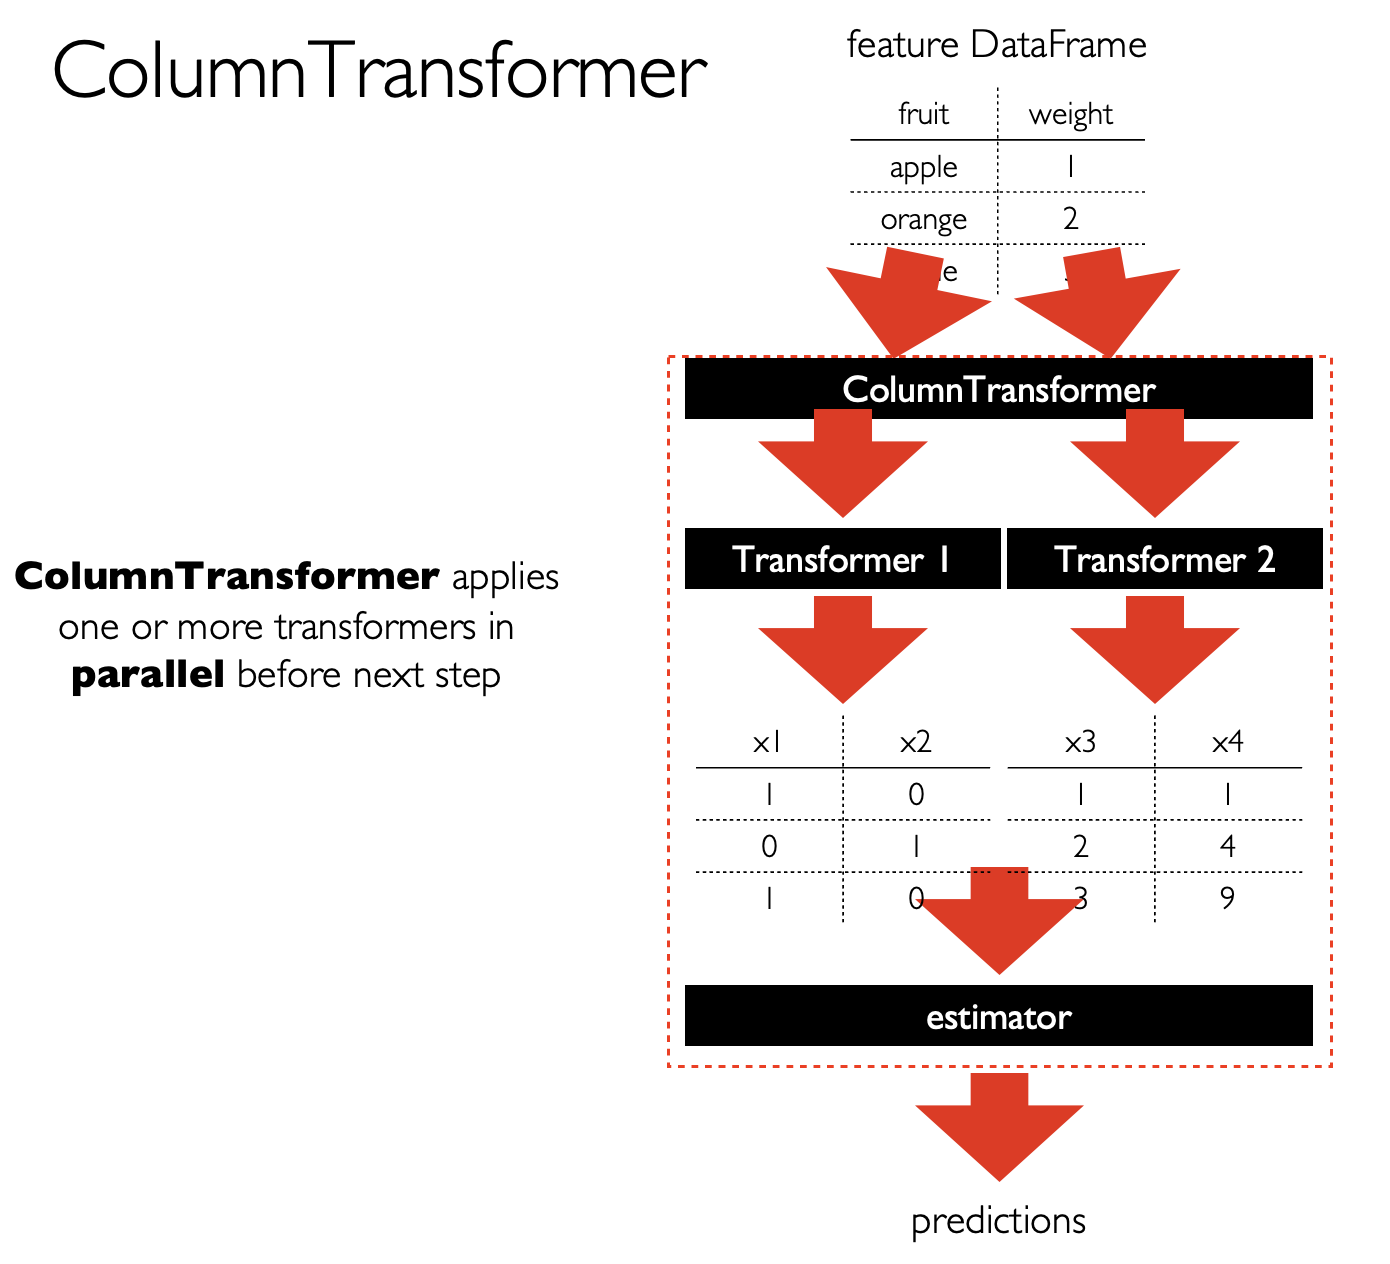
</div>

#### `make_column_transformer(...)`

- Argument: transformations
    - each transformer argument will be a `tuple` with object instance as first item and list of feature columns as the second
- documention: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html

#### Model 4: Beach Name (Categorical) and Wave Period (Polynomial)

In [ ]:
custom_trans = make_column_transformer(
    # <transformer object>, [LIST OF COLUMNS]
    (PolynomialFeatures(), ["Wave Period"]),
    (OneHotEncoder(), ["Beach Name"]),
)
custom_trans

In [ ]:
m4 = Pipeline([
    ("transformers", custom_trans),
    ("lr", LinearRegression()),
])
m4

In [ ]:
xcols = ["Beach Name", "Wave Period"]

In [ ]:
scores = cross_val_score(m4, train[xcols], train[ycol], cv=10)
scores.mean()

**Conclusion:** mean R^2 score increased to 0.0885 when compared to 0.0489 (polynomial).

### Let's evaluate this model by running it against the test data

In [ ]:
m4.fit(train[xcols], train[ycol])
m4.score(test[xcols], test[ycol])

#### How to extract `coef_` for this `Pipeline`?

- `Pipeline` object instance works like a dictionary when we specify names in the inner tuples.
- We can use the name as key to lookup the associated details.

In [ ]:
m4["transformers"]

In [ ]:
m4["lr"].coef_

In [ ]:
# Let's get the names of the features
m4["transformers"].get_feature_names_out()

In [ ]:
# Now let's get the coefficients
m4["lr"].coef_

In [ ]:
s = pd.Series(m4["lr"].coef_, index=m4["transformers"].get_feature_names_out())
s.plot.bar()

In [ ]:
# Bar horizontal plot will be slightly better in terms of readability


What are the beaches that have the biggest waves?

# Linear Algebra

- Installation requirements: `pip3 install rasterio Pillow`

### Where do numpy arrays show up in ML?

- A `DataFrame` is just a matrix wihout column names or row indices

In [ ]:
df = pd.DataFrame([[0, 2, 1], [2, 3, 4], [8, 5, 6]], columns=["x1", "x2", "y"])
df

`df.values` gives us a `numpy.ndarray` of all the values.
`nd` stands for n-dimensional:
- 2-dimensional for matrix
- 1-dimensional for vector

In [ ]:
print(type(df.values))
df.values

In [ ]:
model = LinearRegression()
model.fit(df[["x1", "x2"]], df["y"])
model.coef_

In [ ]:
model.predict(df[["x1", "x2"]])

#### How does `predict` actually work?

- Matrix multiplication with coefficients (`@`) and add intercept

In [ ]:
df[["x1", "x2"]].values @ model.coef_ + model.intercept_

### How to create numpy arrays from scratch?

- requires `import numpy as np`
    - `np.array(<object>)`: creates numpy array from object instance; documentation: https://numpy.org/doc/stable/reference/generated/numpy.array.html
    - `np.ones(<shape>)`: creates an array of ones; documentation: https://numpy.org/doc/stable/reference/generated/numpy.ones.html
    - `np.zeros(<shape>)`: creates an array of zeros; documentation: https://numpy.org/doc/stable/reference/generated/numpy.zeros.html

In [ ]:
# Creating numpy array using np.array
[7, 8, 9]

In [ ]:
# Creating numpy array of 8 1's


In [ ]:
# Creating numpy array of 8 0's


#### Review: `range()`

In [ ]:
# 0 to exclusive end
# range(END)
list(range(10))

In [ ]:
# inclusive start to exclusive end
# range(START, END)
list(range(-4, 10))

In [ ]:
# inclusive start to exclusive end with a step between values
# default STEP is 1
# range(START, END, STEP)
list(range(-4, 10, 2))

In [ ]:
# range cannot have floats for the STEP
list(range(-4, 10, 0.5))

#### Back to `numpy`
- `np.arange([start, ]stop, [step, ])`: gives us an array based on range; documentation: https://numpy.org/doc/stable/reference/generated/numpy.arange.html

In [ ]:
# array range
np.arange(-4, 10, 0.5)   

#### Review: Slicing

- `seq_object[<START>:<exclusive_END>:<STEP>]`
    - `<START>` is optional; default is index 0
    - `<END>` is optional; default is `len` of the sequence
- slicing creates a brand new object instance

In [ ]:
# REVIEW: Python slicing of lists
a = [7, 8, 9, 10]
# slice out 8 and 10
b = a[1::2] 
b

In [ ]:
b[1] = 100
b

In [ ]:
# original object instance doesn't change
a

Slicing is slow because of creating a new object instance.

#### How to slice `numpy` arrays? 
- Unlike regular slicing `numpy` slicing is very efficient - doesn't do a copy

In [ ]:
a = np.array([7, 8, 9, 10])
# slice out 8 and 10
b = a[1::2]  
b

In [ ]:
b[1] = 100
a

How can you ensure that changes to a slice don't affect original `numpy.array`? Use `copy` method.

In [ ]:
a = np.array([7, 8, 9, 10])
b = a.copy() # copy everything instead of sharing
b = a[1::2] 
b[1] = 100
b, a

#### Creating Multi-Dimensional Arrays

- using nested data structures like list of lists
- `shape` gives us the dimension of the `numpy.array`
- `len()` gives the first dimension, that is `shape[0]`

In [ ]:
a = np.array([1, 2, 3])
a, len(a)

How many numbers are there in the below `tuple`?

In [ ]:
# shape of numpy array


One number in this `tuple`, and it is 3.

In [ ]:
# 2-D array using list of lists
b = np.array([[1, 2, 3], [4, 5, 6]])
b

In [ ]:
b.shape

2 dimensional (because two numbers are there in this `tuple`). sizes 2 and 3 along those dimensions.

In [ ]:
# gives shape[0]
len(b)

#### How to reshape a `numpy.array`?

- `<obj>.reshape(<newshape>)`: reshapes the dimension of the array; documentation: https://numpy.org/doc/stable/reference/generated/numpy.reshape.html

In [ ]:
b

In [ ]:
# Use .reshape to change the dimensions to 3 x 2


In [ ]:
# Use .reshape to change to 1-dimensional array


We cannot add/remove values while reshaping.

In [ ]:
b.reshape(5)

In [ ]:
b.reshape(7)

-1 means whatever size is the necessary shape for the remaining values. Enables us to just control one of the dimensions.

In [ ]:
# Use .reshape to change the dimensions to 3 x something valid


In [ ]:
# Use .reshape to change the dimensions to 1-dimensionl using -1


Generate a 10*10 with numbers from 0 to 99.

In [ ]:
# Use arange and then reshape it to 10 x something valid


### Vocabulary
- scalar: 0 dimensional array
- vector: 1 dimensional array
- matrix: 2 dimensional array
- tensor: n dimensional (0, 1, 2, 3, ...) array 

### Images as Tensors

- `wget` command:
    - `wget <url> -O <local file name>`

In [ ]:
# Only run this cell once
!wget "https://upload.wikimedia.org/wikipedia/commons/f/f2/Coccinella_magnifica01.jpg" -O bug.jpg

#### How to read an image file?

- required `import matplotlib.pyplot as plt`
    - `plt.imread(<fname>)`: reads an image file into a 3-dimensional array --- rows(pixels), columns(pixels), colors (red/green/blue)
    - `plt.imshow(<array>, cmap=<color map>)`: displays the image

In [ ]:
a = plt.imread("bug.jpg")
type(a)

In [ ]:
# 3-dimensional array
# rows(pixels), columns(pixels), colors (red/green/blue)
a.shape

In [ ]:
plt.imshow(a)

In [ ]:
a 
# each inner array has 3-color representation R, G, B
# two color scales: floats (0.0 to 1.0) OR ints (0 to 255)

#### GOAL: crop down just to the bug using slicing

- `<array>[ROW SLICE, COLUMN SLICE, COLOR SLICE]`

In [ ]:
plt.imshow(a[???, ???, :])

#### GOAL: show clearly where RED is high on the image
- two formats:
    - 3D (row, column, color)
    - 2D (row, column) => black/white (red/blue)

In [ ]:
a.shape

Pull out only layer 0, which is the red layer.
- 0 is red
- 1 is green
- 2 is blue

Use index only for the color dimension and slices for row and column dimensions

In [ ]:
a[:, :, 0].shape 

In [ ]:
# instead of using black and white, 
# it is just assigning some color for light and dark
plt.imshow(a[:, :, 0])

In [ ]:
# better to use grayscale
plt.imshow(a[:, :, 0], ???)

Wherever there was red, the image is bright. The bug is very bright because of that. There are other places in the image that are bright but were not red. This is because when we mix RGB, we get white. Any color that was light will also have a lot of RED.

This could be a pre-processing step for some ML algorithm that can identify RED bugs. 

#### GOAL: show a grayscale that considers the average of all colors

- `<array>.mean(axis=<val>)`:
    - `axis` should be 0 for 1st dimension, 1 for 2nd dimension, 2 for 3rd dimension

In [ ]:
# average over all the numbers
# gives a measure of how bright the image is overall
a.mean()

In [ ]:
a.shape

In [ ]:
# average over each column and color combination
a.mean(axis=0).shape

In [ ]:
# average over each row and color combination
a.mean(axis=1).shape

In [ ]:
# average over each row and column combination
a.mean(axis=2).shape

In [ ]:
plt.imshow(a.mean(axis=2), cmap="gray")

This could also be a pre-processing step for some ML algorithm that expects black and white images.

### Vector Multiplication: Overview

#### Elementwise Multiplication

$\begin{bmatrix}
1 \\ 2 \\ 3
\end{bmatrix}
*
\begin{bmatrix}
4 \\ 5 \\ 6
\end{bmatrix}$

$\begin{bmatrix}
1 \\ 2 \\ 3
\end{bmatrix}
*
\begin{bmatrix}
4 & 5 & 6
\end{bmatrix}$

### Dot Product

$\begin{bmatrix}
1 & 2 & 3
\end{bmatrix}
\cdot
\begin{bmatrix}
4 \\ 5 \\ 6
\end{bmatrix}$

$\begin{bmatrix}
1 \\ 2 \\ 3
\end{bmatrix}
\cdot
\begin{bmatrix}
4 & 5 & 6
\end{bmatrix}$

In [ ]:
# Use .reshape to change the dimensions to something valid x 1 
# vertical shape
v1 = np.array([1, 2, 3])
v1

In [ ]:
v2 = np.array([4, 5, 6]).reshape(-1, 1)
v2

Elementwise multiplication:

In [ ]:
v1 * v2   # [1*4, 2*5, 3*6]

#### Transpose

- flips the x and y

In [ ]:
v2

In [ ]:
v2.T # horizontal

In [ ]:
v2.T.T # vertical

In [ ]:
v1.shape

In [ ]:
v2.T.shape

In [ ]:
v1 * v2.T # how is this working?